## COPT Callback功能 -- 求解STSP问题

我们将在**人造数据集**和真实的**中国省份经纬度数据**上分别求解STSP问题，问题中的距离（成本）采用欧氏距离。

### 人造数据集

#### 生成数据

这里我们使用`numpy`在二维平面随机生成`nCities=20`个城市的坐标，每个城市的每个坐标都互相独立且服从$[0,1]$上的均匀分布。

- `cities`是$nCities\times 2$的二维`numpy`数组，`cities[i]`记录了城市$i$的二维坐标。
- `distances`是Python字典，`distances[(i,j)]`记录城市$i$和城市$j$的欧式距离，且有`distances[(i,j)]=distances[(j,i)]`。
- `edges`是Python列表，记录了所有的边`(i,j)`，共$n(n-1)$条。

In [1]:
import numpy as np

np.random.seed(1)
nCities = 20
cities = np.random.rand(nCities, 2)
distances = dict()

for i in range(nCities):
    for j in range(i+1,nCities):
        distances[(i,j)] = np.linalg.norm(cities[i]-cities[j])
        distances[(j,i)] = distances[(i,j)]

edges = list(distances.keys())

我们使用`matplotlib`可视化城市的位置。

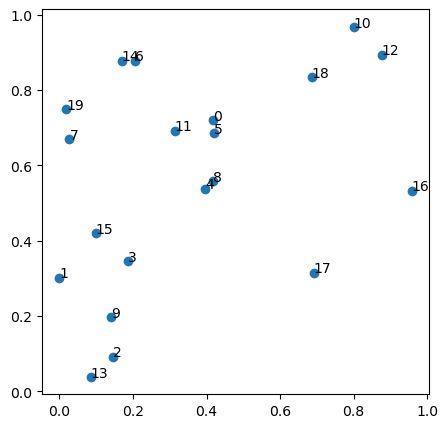

In [2]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5,5))
plt.scatter(cities[:,0],cities[:,1],marker='o')
for i in range(nCities):
    plt.text(cities[i,0],cities[i,1],i)
plt.show()

#### 创建COPT环境

你大概对这一步已经很熟悉了，我们使用了`Envr()`创建了一个COPT环境，并在其中使用`Env.createModel()`创建了一个名为`ip_stsp`的模型。

In [3]:
from coptpy import *

# tested with Python 3.10 & COPT 6.5.0

# Create COPT environment
env = Envr()

# Create COPT model
model = env.createModel("ip_stsp")

Cardinal Optimizer v6.5.0. Build date Mar 24 2023
Copyright Cardinal Operations 2023. All Rights Reserved



#### 向COPT描述问题

##### 添加变量

这里我们使用`addVars()`为所有的边添加0-1指示变量，变量类型为`COPT.BINARY`。

In [4]:
e = model.addVars(edges, vtype=COPT.BINARY, nameprefix='e')

##### 添加部分约束

我们先添加"对称"约束和"城市只经过一次"的约束
$$
\begin{aligned}
&\sum_{j\in V,j\neq i}x_{ij} = 2, &\forall i\in V \\
&x_{ij} = x_{ji}, &\forall i,j\in V,i\neq j
\end{aligned}
$$

对于求和的形式，我们已经在快速入门中见识过`tupledict.sum()`的便捷，但$\forall i\in V$可能会让你头疼。我们可以使用`for`循环加上`addConstr()`实现任务，但正如`addVar()`与`addVars()`一样，我们可以使用`addConstrs()`方法更优雅地批量加入约束。

`Model.addConstrs(generator, nameprefix="R")`可以实现批量添加约束，只需要使用类似Python列表解析（`newlist = [expression for item in iterable if condition == True]`）的语法，具体使用只需看下面的例子就一目了然。

In [5]:
model.addConstrs(e.sum(i,'*') == 2 for i in range(nCities))
model.addConstrs(e[i,j] == e[j,i] for i,j in edges)

#### 处理“消除子环”约束

直接向`model`添加“消除子环”约束并不是明智的做法。我们先来计算一下大概会有多少个“消除子环”约束。
$$\frac{1}{2}\sum_{(i,j)\in S} x_{ij} \leq |S|-1, \forall S\subset V,3\leq |S| \leq n-2$$
我们拿城市集合的全部子集个数（$2^{n}$个）减去0元、1元、2元、$n-1$元和$n$元子集：

In [6]:
2**nCities - 1 - nCities - nCities*(nCities-1)/2 - nCities - 1

1048344.0

仅`nCities=20`个城市，就已经有1048344个“消除子环”约束！一方面，我们不希望直接添加这么多约束，因为这会使问题非常难解。另一方面，原问题的决策变量远小于“消除子环”约束个数，说明在原问题的最优解中，绝大多数“消除子环”约束都是没必要存在的。

一个常用的思路是**松弛**。我们直接“丢弃”一部分约束，使得优化问题的可行集变大，如果在这个新问题下的最优解还能在原问题中可行，那么我们就找到了原问题的最优解。

具体而言，“消除子环”约束本来是为了防止子环出现，但如果仅靠其余约束就能找到一条没有子环的路径，那原问题也就被我们解决了。**松弛**值得一试！

##### 设定目标函数

在求解问题之前，别忘了添加目标函数。
$$
\min\ \sum_{i,j\in V,i\neq j} d_{ij}x_{ij}
$$
虽然我们已经能够使用`tupledict.sum()`处理求和，但是这次的求和带上了系数$d_{ij}$，`tupledict.sum()`似乎不太容易使用。

COPT预料到了这种情况，并为我们提供了`tupledict.prod(coeff, pattern)`函数。回忆字典`distances`的结构，它的键$(i,j)$与决策变量的`tupledict`对象`e`的键相匹配，于是使用`e.prod(distances)`会将$x_{ij}$与$d_{ij}$相乘并将各结果相加，这正是我们想要的。

In [7]:
model.setObjective(e.prod(distances),sense=COPT.MINIMIZE)

**定义搜索子回路函数**

In [8]:
# Given a tuplelist of edges, find the shortest subtour
def subtour(vals):
    # make a list of edges selected in the solution
    edges = tuplelist((i, j) for i, j in vals.keys()
                         if vals[i, j] > 0.5)
    unvisited = list(range(nCities))

    # initial length has 1 more city
    cycle = range(nCities+1)
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

**定义callback类及其成员函数**

In [9]:
# Define the callback class
class CoptCallback(CallbackBase):
    def __init__(self, vars):
        super().__init__()
        self.vars = vars

    def callback(self):
        if self.where() == COPT.CBCONTEXT_MIPSOL:
            vars = self.vars
            vals = self.getSolution(vars) # vals is a tupledict (feasible solution)
            tour = subtour(vals)
            if len(tour) < nCities:
                self.addLazyConstr(quicksum(vars[tour[i], tour[i+1]] for i in range(len(tour)-1)) + vars[tour[-1], tour[0]] <= len(tour)-1)

**调用callback函数**

In [10]:
cb = CoptCallback(e)
model.setCallback(cb, COPT.CBCONTEXT_MIPSOL)
model.solve()

No license found. The size is limited to 2000 variables and 2000 constraints
Please apply for a license from www.shanshu.ai/copt

Model fingerprint: 5d6a39cf

Using Cardinal Optimizer v6.5.0 on Windows
Hardware has 4 cores and 8 threads. Using instruction set X86_AVX2 (10)
Minimizing a MIP problem

The original problem has:
    400 rows, 380 columns and 1140 non-zero elements
    380 binaries

Presolving the problem

The presolved problem has:
    20 rows, 190 columns and 380 non-zero elements
    190 binaries

Starting the MIP solver with 8 threads and 32 tasks

     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution    Gap   Time
         0         1      --       0  0.000000e+00            --    Inf  0.01s
         0         1      --       6  6.515777e+00            --    Inf  0.06s
         0         1      --       8  6.776439e+00            --    Inf  0.08s
         0         1      --      12  6.818046e+00            --    Inf  0.09s
         0         1      --      1

#### 查看结果

我们定义两个函数`get_path()`和`draw_path()`。

- `get_path()`可以从最优解中获取选择的路径

- `draw_path()`会将选择的路径画出来

其中，在`get_path()`中我们遇到了一些COPT的新老面孔。
- 我们已经见过了`getVars()`，它可以获取模型变量，以进一步获取变量信息。
- `var.x`能够访问变量最优取值，我们还见过`var.name`等。
- `model.Param.IntTol`是COPT的内置参数常数之一。为了数值稳定性，求解器往往会引入容差（tolerance），于是即使是0-1变量，在最优解中`var.x`也可能会取$0.999999$这样的数值，此时如果直接判断`var.x == 1`会得到`False`，所以这里也使用容差判断。COPT还有很多参数常数，我们建议你查阅<a href="https://www.shanshu.ai/copt-document/manual?id=19&docType=3" target="_blank">COPT Python API</a>进一步了解。
- `var.getIdx()`与`var.index`作用相同，都可以访问到变量的序号。这里$x_{ij}$在模型变量中的次序与其对应的边$(i,j)$在`edges`中的次序一致。

In [11]:
def get_path():
    '''
    get path from optimal solution
    '''
    path = []
    allvars = model.getVars()
    
    for var in allvars:
        if var.x >= 1 - model.Param.IntTol:
            path.append(edges[var.getIdx()])
            
    return path

def draw_path():
    '''
    draw the path
    '''
    path = get_path()

    plt.figure(figsize=(5,5))
    plt.scatter(cities[:,0],cities[:,1],marker='o')
    
    for i in range(nCities):
        plt.text(cities[i,0],cities[i,1],i)
        
    for i in path:
        plt.plot([cities[i[0],0],cities[i[1],0]],[cities[i[0],1],cities[i[1],1]], color='red')

    plt.show()

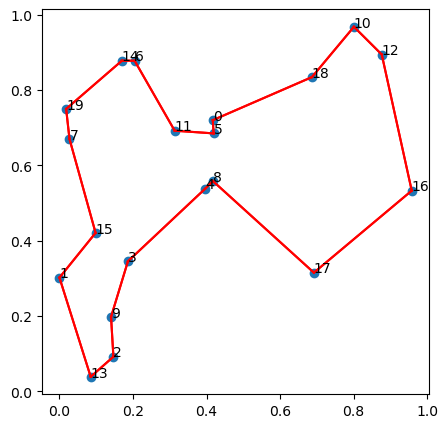

7.342306618738267

In [12]:
draw_path()
model.objval

至此，我们与COPT默契配合，完成了STSP问题求解的一次尝试。调用COPT 6.5的Callback功能，实现了逐步消除子环的算法思想。

下面我们将使用真实的中国各省份经纬度数据建立STSP问题，回顾我们刚才使用的方法，完成一次**环游全中国**。

### 中国省份经纬度数据

#### 数据准备

使用真实的中国各省份经纬度数据，相应地创建`nCities`、`cities`、`city_list`、`distances`和`edges`。

In [13]:
provinces = {
    '吉林省': [125.326800, 43.896160], '黑龙江省': [126.662850, 45.742080],
    '辽宁省': [123.429250, 41.835710], '内蒙古自治区': [111.765220, 40.817330],
    '新疆维吾尔自治区': [87.627100, 43.793430], '青海省': [101.780110, 36.620870],
    '北京市': [116.407170, 39.904690], '天津市': [117.199370, 39.085100],
    '上海市': [121.473700, 31.230370], '重庆市': [106.550730, 29.564710],
    '河北省': [114.469790, 38.035990], '河南省': [113.753220, 34.765710],
    '陕西省': [108.954240, 34.264860], '江苏省': [118.762950, 32.060710],
    '山东省': [117.020760, 36.668260], '山西省': [112.562720, 37.873430],
    '甘肃省': [103.826340, 36.059420], '宁夏回族自治区': [106.258670, 38.471170],
    '四川省': [104.075720, 30.650890], '西藏自治区': [91.117480, 29.647250],
    '安徽省': [117.285650, 31.861570], '浙江省': [120.153600, 30.265550],
    '湖北省': [114.342340, 30.545390], '湖南省': [112.983400, 28.112660],
    '福建省': [119.296590, 26.099820], '江西省': [115.910040, 28.674170],
    '贵州省': [106.707220, 26.598200], '云南省': [102.709730, 25.045300],
    '广东省': [113.266270, 23.131710], '广西壮族自治区': [108.327540, 22.815210],
    '香港': [114.165460, 22.275340], '澳门': [113.549130, 22.198750],
    '海南省': [110.348630, 20.019970], '台湾省': [121.520076, 25.030724],
}

nCities = len(provinces)
city_list = list(provinces.keys())
cities = np.array(list(provinces.values()))
distances = dict()

for i in range(nCities):
    for j in range(i+1,nCities):
        distances[(i,j)] = np.linalg.norm(np.array(provinces[city_list[i]])-np.array(provinces[city_list[j]]))
        distances[(j,i)] = distances[(i,j)]

edges = list(distances.keys())

#### 描述松弛问题

这里我们需要先使用`model.clear()`清空之前构造的模型，再重新添加新的变量和约束，这里我们依然先不添加“消除子环”约束。

In [14]:
model.clear()

e = model.addVars(edges, vtype=COPT.BINARY, nameprefix='e')

model.addConstrs(e.sum(i,'*') == 2 for i in range(nCities))
model.addConstrs(e[i,j] == e[j,i] for i,j in edges)

model.setObjective(e.prod(distances),sense=COPT.MINIMIZE)

In [15]:
plt.rcParams['font.sans-serif'] = ['SimHei']
def draw_provinces():
    path = get_path()

    plt.figure(figsize=(16,9))
    plt.scatter(cities[:,0],cities[:,1],marker='o')
    
    for i in range(nCities):
        plt.text(cities[i,0],cities[i,1],city_list[i])
        
    for i in path:
        plt.plot([cities[i[0],0],cities[i[1],0]],[cities[i[0],1],cities[i[1],1]], color='red')

    plt.show()

**调用callback函数**

In [16]:
cb = CoptCallback(e)
model.setCallback(cb, COPT.CBCONTEXT_MIPSOL)
model.solve()

No license found. The size is limited to 2000 variables and 2000 constraints
Please apply for a license from www.shanshu.ai/copt

Model fingerprint: 97d83d95

Using Cardinal Optimizer v6.5.0 on Windows
Hardware has 4 cores and 8 threads. Using instruction set X86_AVX2 (10)
Minimizing a MIP problem

The original problem has:
    1156 rows, 1122 columns and 3366 non-zero elements
    1122 binaries

Presolving the problem

The presolved problem has:
    34 rows, 561 columns and 1122 non-zero elements
    561 binaries

Starting the MIP solver with 8 threads and 32 tasks

     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution    Gap   Time
         0         1      --       0  0.000000e+00            --    Inf  0.02s
         0         1      --       6  2.777952e+02            --    Inf  0.04s
         0         1      --       8  2.781657e+02            --    Inf  0.07s
         0         1      --       6  3.008518e+02            --    Inf  0.07s
         0         1      --   

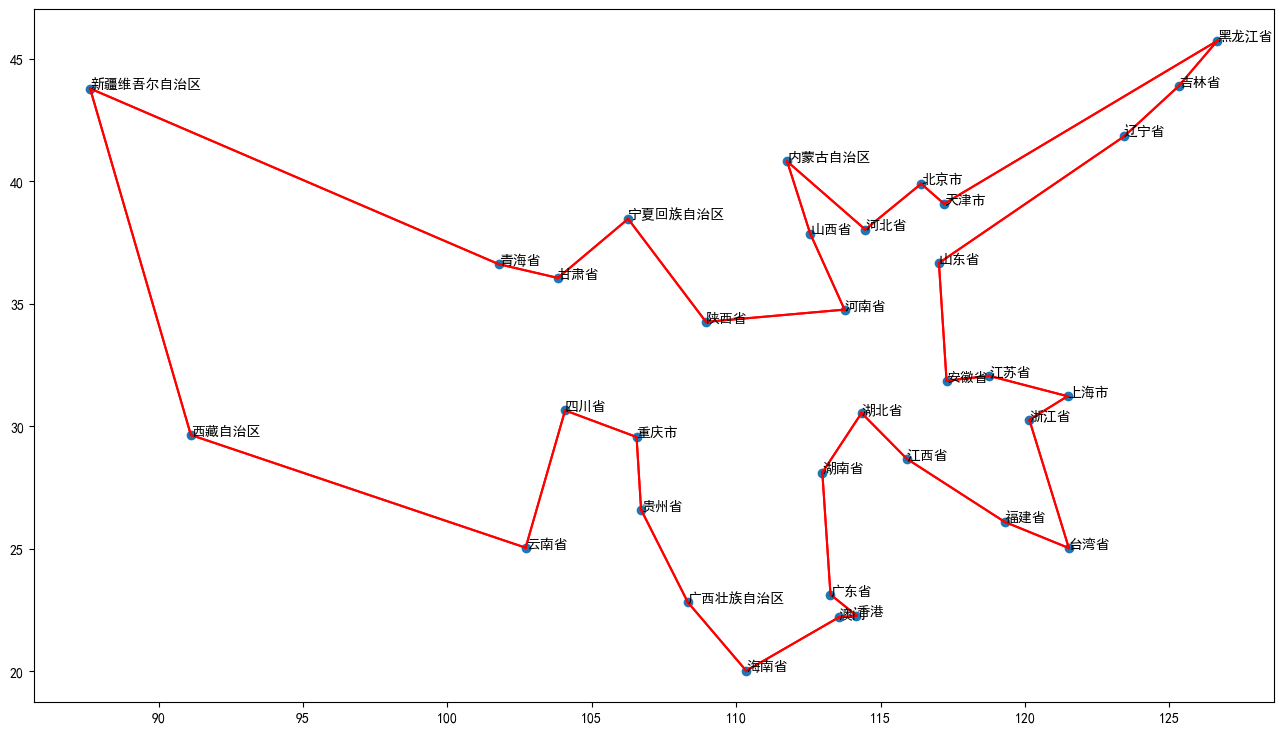

In [17]:
if model.status == COPT.OPTIMAL: 
    draw_provinces()